In [1]:

%load_ext autoreload
%autoreload 2
%pip install hmmlearn
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import paths_cpt 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, RocCurveDisplay, silhouette_score
import os
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from seglearn.transform import FeatureRep, SegmentX
from seglearn.pipe import Pype
from seglearn.datasets import load_watch
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import random

print(os.getcwd())
seed = 22

df = pd.read_parquet(paths_cpt.PATH_TO_PARQUET)
print(df.shape)
df.dropna(inplace=True)
df.head()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\volte\OneDrive\Dokumente\usecase_cpt\CPT_usecase\modeling
(1222711, 19)


,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,2593,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07,Quartair
1,314,2594,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07,Quartair
2,314,2595,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07,Quartair
3,314,2596,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09,Quartair
4,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07,Quartair


In [2]:
vec_lengths = []
for id in df.sondering_id.unique():
    vec_lengths.append(df[df["sondering_id"] == id].shape[0])
print(sum(vec_lengths) / len(vec_lengths))

760.0790697674419


In [3]:
# quickly looking at segments with more than 1 occurrence,will replace once we have this data from the company

segments_oi = [
    "Merelbeke",
    "Sint_Huibrechts_Hern",
    "Ursel",
    "Kwatrecht",
    "Asse",
    "Aalbeke",
    "Wemmel",
    "Onbekend",
    "Mons_en_Pevele",
    "Mont_Panisel",
    "Brussel",
    "Lede",
    "Quartair"
]

In [4]:
# doing an encoding for things that need numeric outcomes, read that for HMM this would be teh way to encode the states 
# (one coliumn with numeric values, does not imply that they are ordered, might be wrong though)
mapping = {i:j for i,j in zip(df.lithostrat_id.unique(), range(0, len(df.lithostrat_id.unique()))) if i in segments_oi}
mapping

{'Quartair': 0,
 'Mont_Panisel': 1,
 'Aalbeke': 2,
 'Mons_en_Pevele': 3,
 'Brussel': 8,
 'Onbekend': 9,
 'Ursel': 10,
 'Asse': 11,
 'Wemmel': 12,
 'Lede': 13,
 'Merelbeke': 16,
 'Kwatrecht': 17,
 'Sint_Huibrechts_Hern': 26}

In [5]:
df["lithostrat_int"] = df.lithostrat_id.map(mapping)
df.dropna(inplace=True)

In [6]:
#target set with unknowns, other set without unknowns
target_set = df[(df["lithostrat_id"].isna()) | (df["lithostrat_id"]=="None") | df["lithostrat_id"].str.contains('Onbekend')]
train_set = df[~((df["lithostrat_id"].isna()) | (df["lithostrat_id"]=="None") | df["lithostrat_id"].str.contains('Onbekend'))]
print("rows in train and target are : ", train_set.shape[0], " ; ", target_set.shape[0], ",",\
       target_set.shape[0] + train_set.shape[0], " = ", df.shape[0])

rows in train and target are :  131515  ;  14172 , 145687  =  145687


In [7]:
#train_set = train_set[['diepte',
 #      'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_int']]
drillings = df.sondering_id.unique()
print(len(drillings) * (3/4))

drillings = drillings[0:159]

train = train_set[train_set.sondering_id.isin(drillings)]
test = train_set[~train_set.sondering_id.isin(drillings)]
X_train, y_train = train[['diepte',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']], train["lithostrat_int"]
X_test, y_test = test[['diepte',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']], test["lithostrat_int"]

156.75


## HMM experimentation

In [8]:
# this one sucks
#train_set = [] 
train_lengths = []
test_lengths = []
states = segments_oi

# Split based on drillings
hmm_train_set = train_set[train_set.sondering_id.isin(drillings)]
hmm_test_set = train_set[~train_set.sondering_id.isin(drillings)]

hmm_X_train = []
hmm_X_test = []

# we have to do this iteration to build numpy arrays for the hmm. 
for id in hmm_train_set.sondering_id.unique():
    subdf = hmm_train_set[hmm_train_set["sondering_id"] == id].copy()
    substate = subdf["icn"].values
    if len(substate) < 700:
        sublength = len(substate)
        pad_length = 700 - sublength
        substate = np.pad(np.asarray(substate, dtype="float64"), (0, pad_length),
                          mode='constant', constant_values=0)
        hmm_X_train.append(substate)
        train_lengths.append(700)

# same for test
for id in hmm_test_set.sondering_id.unique():
    subdf = hmm_test_set[hmm_test_set["sondering_id"] == id].copy()
    substate = subdf["icn"].values
    if len(substate) < 700:
        sublength = len(substate)
        pad_length = 700 - sublength
        substate = np.pad(np.asarray(substate, dtype="float64"), (0, pad_length),
                          mode='constant', constant_values=0)
        hmm_X_test.append(substate)
        test_lengths.append(700)

#we need to do some reshapings for the format to be right 
hmm_X_train = np.asarray(hmm_X_train, dtype="object")
hmm_X_train = np.concatenate(hmm_X_train).reshape(-1, 1)
hmm_X_test = np.asarray(hmm_X_test, dtype="object")
hmm_X_test = np.concatenate(hmm_X_test).reshape(-1, 1)

#we finally fit the model
hmm_model = hmm.GaussianHMM(n_components=3).fit(hmm_X_train, train_lengths)
test_score = hmm_model.score(hmm_X_test, test_lengths)
print("Test log-likelihood:", test_score)

Test log-likelihood: 29532.04865377126


In [9]:
log_likelihood = hmm_model.score(hmm_X_test, test_lengths)
print("Log-likelihood:", log_likelihood)

Log-likelihood: 29532.04865377126


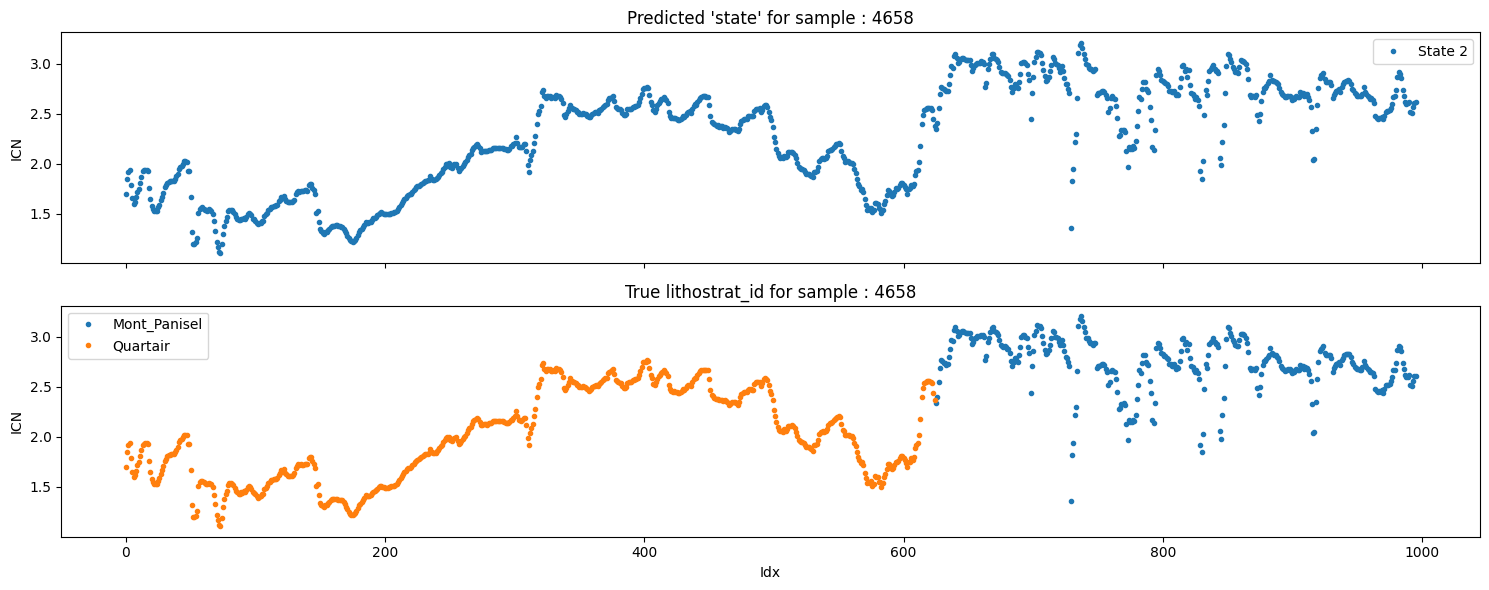

In [10]:

sample_id = hmm_test_set.sondering_id.unique()[0]
subdf = hmm_test_set[hmm_test_set["sondering_id"] == sample_id].copy()
signal = subdf["icn"].values

if len(signal) < 700:
    pad_length = 700 - len(signal)
    signal = np.pad(signal, (0, pad_length), mode='constant', constant_values=0)

signal_reshaped = signal.reshape(-1, 1)
hidden_states = hmm_model.predict(signal_reshaped, [len(signal_reshaped)])


fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

for state in np.unique(hidden_states):
    idx = np.where(hidden_states == state)[0]
    axes[0].plot(idx, signal[idx], '.', label=f'State {state}')
axes[0].set_title(f"Predicted 'state' for sample : {sample_id}")
axes[0].set_ylabel("ICN")
axes[0].legend()

true_states = subdf["lithostrat_id"]
for state in np.unique(subdf.lithostrat_id):
    idx = np.where(true_states == state)[0]
    axes[1].plot(idx, signal[idx], '.', label=f'{state}')
axes[1].set_title(f"True lithostrat_id for sample : {sample_id}")
axes[1].set_xlabel("Idx")
axes[1].set_ylabel("ICN")
axes[1].legend()

plt.tight_layout()
plt.show()

## PCA and LDA related stuff

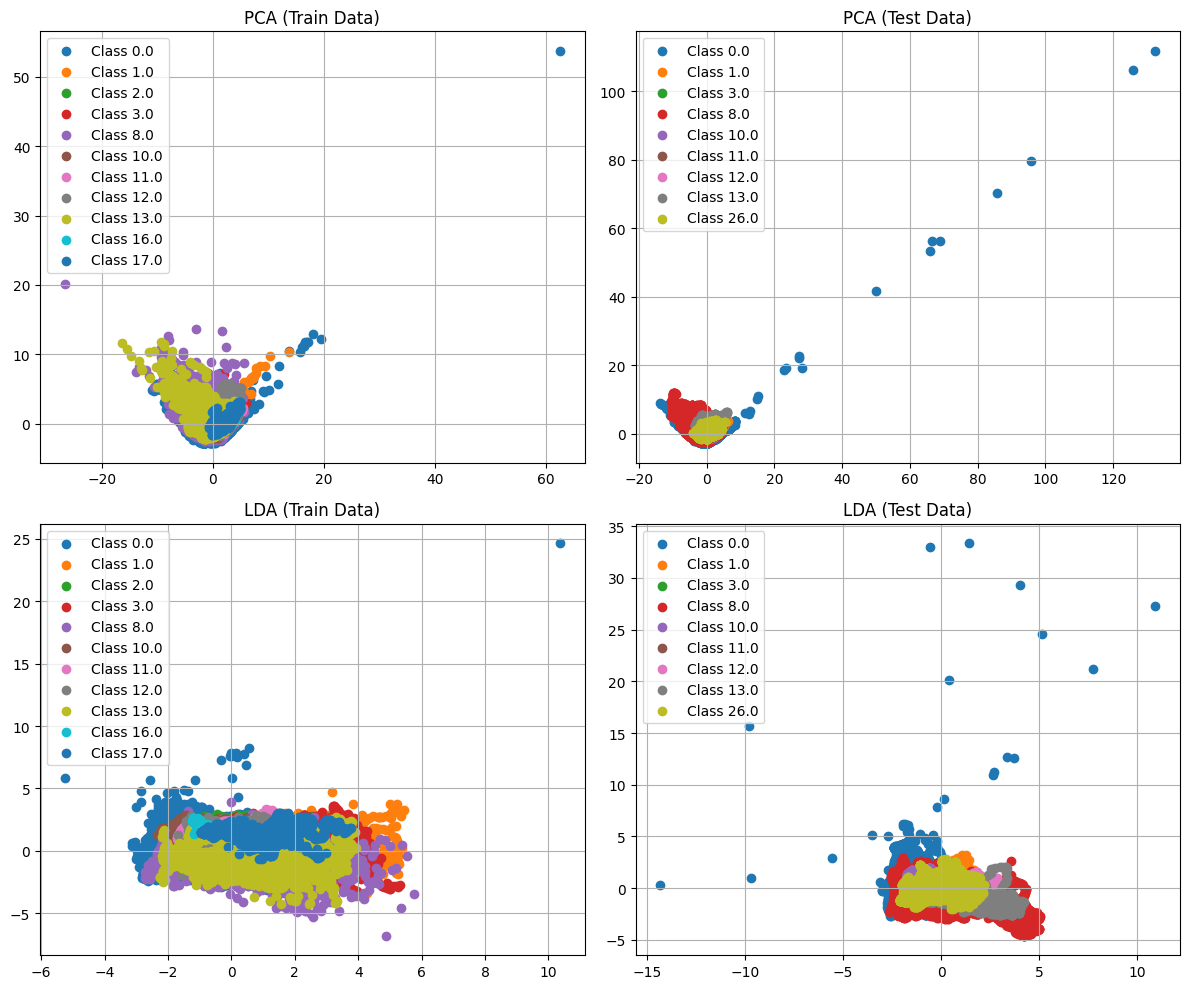

In [11]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

def plot_projection(X_proj, y, title, ax):
    for label in np.unique(y):
        ax.scatter(
            X_proj[y == label, 0],
            X_proj[y == label, 1],
            label=f"Class {label}",
        )
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_projection(X_train_pca, y_train, "PCA (Train Data)", axes[0, 0])
plot_projection(X_test_pca, y_test, "PCA (Test Data)", axes[0, 1])
plot_projection(X_train_lda, y_train, "LDA (Train Data)", axes[1, 0])
plot_projection(X_test_lda, y_test, "LDA (Test Data)", axes[1, 1])

plt.tight_layout()
plt.show()

In [12]:
#This cell runs for approximately 4:30 minutes

#important
print(pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.sum())

#not important
X_train_proj = pca.transform(X_train_std)
X_train_recon = pca.inverse_transform(X_train_proj)
pca_recon_error = np.mean((X_train_std - X_train_recon) ** 2)
print("PCA reconstruction MSE (train):", pca_recon_error)

#not important 
silhouette_train_pca = silhouette_score(X_train_proj, y_train)
print("PCA silhouette score (train):", silhouette_train_pca)

##important
X_test_proj = pca.transform(X_test_std)
silhouette_test_pca = silhouette_score(X_test_proj, y_test)
print("PCA silhouette score (test):", silhouette_test_pca)

#important
print("LDA explained variance ratio:", lda.explained_variance_ratio_)

#important
scores_lda = cross_val_score(lda, X_train_std, y_train, cv=5)
print("LDA cross-validated accuracy (train folds):", scores_lda.mean())

#important
X_train_lda_proj = lda.transform(X_train_std)
silhouette_train_lda = silhouette_score(X_train_lda_proj, y_train)
print("LDA silhouette score (train):", silhouette_train_lda)

#not sure
test_accuracy = lda.score(X_test_std, y_test)
print("LDA test set accuracy:", test_accuracy)

#important
X_test_lda_proj = lda.transform(X_test_std)
silhouette_test_lda = silhouette_score(X_test_lda_proj, y_test)
print("LDA silhouette score (test):", silhouette_test_lda)

[4.65867848e-01 2.23660870e-01 1.25085722e-01 1.09725997e-01
 3.64533581e-02 2.24610652e-02 1.15903805e-02 4.88310106e-03
 2.71658693e-04]
Cumulative variance: 0.9999999999999998
PCA reconstruction MSE (train): 5.53839671113957e-31
PCA silhouette score (train): -0.09077460561947526
PCA silhouette score (test): -0.07792867061558048
LDA explained variance ratio: [6.06917164e-01 2.61447185e-01 6.77535041e-02 3.89407872e-02
 2.10702866e-02 2.52524500e-03 1.11543643e-03 2.14502393e-04
 1.58887144e-05]
LDA cross-validated accuracy (train folds): 0.5469031191897379
LDA silhouette score (train): -0.05824075278398509
LDA test set accuracy: 0.45544708490529345
LDA silhouette score (test): -0.09601718840391252


## Feature engineering related section, 
 some duplicate imports at the start,
 I tried using the seglearn library but it seemed kind of bad in terms of performance,
 but I don't particularly know how to use it


In [13]:
#feature engineering: sliding windows and temporal aggregations
%pip install -U seglearn
#data = load_watch()

features = ['diepte','qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']

# Construct Xt separately for train and test
def Xt_transform(df, cols):
    """Returns time series features for the seglern library"""
    Xt = df[cols].values.astype(np.float32)
    return Xt

Xt_train = Xt_transform(X_train, features)

Xt_test = Xt_transform(X_test, features)


pipe = Pype([('segment', SegmentX(width=5, overlap=0.1)),
    ('features', FeatureRep()),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())])

pipe.fit([Xt_train], [y_train.values])
score = pipe.score([Xt_test], [y_test.values])
print(score)


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:190: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be u

0.42683780630105017


In [14]:

y_pred = pipe.predict([Xt_test])
print(y_pred)

width = pipe.named_steps['segment'].width
overlap = pipe.named_steps['segment'].overlap
stride = int(width * (1 - overlap))

y_true_segments = [
    y_test.values[i + width - 1] 
    for i in range(0, len(y_test) - width + 1, stride)
]

y_true = y_test.values
print(y_true)
print(len(y_pred), len(y_true_segments))
print(set(y_pred), set(y_true_segments))
all_labels = np.unique(np.concatenate([y_true_segments, y_pred]))

report = classification_report(
    y_true_segments,
    y_pred,
    labels=all_labels,           # ensures all labels are included
    target_names=[str(c) for c in all_labels]
)
print(report)

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\seglearn\feature_functions.py:190: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)


[0. 0. 0. ... 8. 8. 1.]
[0. 0. 0. ... 8. 8. 8.]
12855 12855
{0.0, 1.0, 2.0, 3.0, 8.0, 10.0, 11.0, 12.0, 13.0, 16.0, 17.0} {0.0, 1.0, 3.0, 8.0, 10.0, 11.0, 12.0, 13.0, 26.0}
              precision    recall  f1-score   support

         0.0       0.59      0.83      0.69      3268
         1.0       0.02      0.34      0.03        92
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00        12
         8.0       0.74      0.32      0.44      3754
        10.0       0.46      0.47      0.46       245
        11.0       0.41      0.80      0.54       381
        12.0       0.54      0.42      0.47      1306
        13.0       0.24      0.33      0.28      1800
        16.0       0.00      0.00      0.00         0
        17.0       0.00      0.00      0.00         0
        26.0       0.00      0.00      0.00      1997

    accuracy                           0.43     12855
   macro avg       0.25      0.29      0.24     12855
weighted avg   

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

In [15]:
print(score)

0.42683780630105017


In [16]:
def sliding_window(X, id_column, points=5, features=[], new_cols= ["mean", "slope"]):
    processed_subframes = []
    ids_to_process = X[id_column].unique()
    #features = [c for c in X.columns if c != id_column]

    for id in ids_to_process:
        subdf = X[X[id_column] == id].copy()
        n_rows = len(subdf)
        features_list = []
        
        for start in range(0, n_rows - points + 1):
            window = subdf.iloc[start:start + points]
            feats = window.iloc[-1].to_dict()
            feats[id_column] = id
            
            for col in features:
                col_vals = window[col].values
                feats[f"{col}_mean"] = col_vals.mean()
                feats[f"{col}_slope"] = np.polyfit(np.arange(points), col_vals, 1)[0]
            
            features_list.append(feats)
        
        processed_subframes.append(pd.DataFrame(features_list))
    
    return pd.concat(processed_subframes, ignore_index=True)



train = sliding_window(train, 'sondering_id', features = ['qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt'])
train.head()

,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,...,rf_mean,rf_slope,fr_mean,fr_slope,icn_mean,icn_slope,sbt_mean,sbt_slope,ksbt_mean,ksbt_slope
0,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,...,2.828034,0.017383,2.929968,0.039968,2.576925,0.032710,4.6,-2.000000e-01,2.328600e-07,-2.740000e-09
1,314,2598,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.1,13.16,...,2.701172,-0.027770,2.801396,-0.024404,2.564662,0.014153,4.6,-2.522391e-16,2.482200e-07,-3.211000e-08
2,314,2599,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.2,13.06,...,2.479885,-0.548687,2.575949,-0.581064,2.517331,-0.112146,4.6,2.000000e-01,6.147200e-07,4.263300e-07
3,314,2600,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.3,12.96,...,2.231105,-0.778668,2.321373,-0.839001,2.467513,-0.175019,4.6,4.000000e-01,8.403800e-07,4.642300e-07
4,314,2601,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.4,12.86,...,1.594915,-0.130411,1.629070,-0.136408,2.332234,-0.052963,5.0,-6.490521e-16,1.014000e-06,2.215100e-07


In [17]:
train.columns

Index(['sondering_id', 'index', 'pkey_sondering', 'sondeernummer', 'x', 'y',
       'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id',
       'lithostrat_int', 'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope',
       'qtn_mean', 'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope',
       'icn_mean', 'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean',
       'ksbt_slope'],
      dtype='object')

In [18]:


X = train[['sondering_id', 'diepte', 
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt',
       'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope',
       'qtn_mean', 'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope',
       'icn_mean', 'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean',
       'ksbt_slope']]

y = train[['sondering_id', 'lithostrat_id', 'lithostrat_int']]

In [19]:

drillings = X.sondering_id.unique()
random.shuffle(drillings)
print(len(drillings) * (3/4))

drillings = drillings[0:117]

X_train, y_train, X_test, y_test = X[X.sondering_id.isin(drillings)], y[y.sondering_id.isin(drillings)],X[~X.sondering_id.isin(drillings)], y[~y.sondering_id.isin(drillings)], 
X_test.shape

116.25


(22894, 26)

In [20]:
model1 = RandomForestClassifier(
    n_estimators=200,
    random_state=seed,
    class_weight='balanced'
)

features = ['diepte', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt',
       'ksbt', 'qc_mean', 'qc_slope', 'fs_mean', 'fs_slope', 'qtn_mean',
       'qtn_slope', 'rf_mean', 'rf_slope', 'fr_mean', 'fr_slope', 'icn_mean',
       'icn_slope', 'sbt_mean', 'sbt_slope', 'ksbt_mean', 'ksbt_slope']

model1.fit(X_train[features], y_train['lithostrat_id'])

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
y_pred = model1.predict(X_test[features])
accuracy = accuracy_score(y_test["lithostrat_id"], y_pred)
print("Overall accuracy:", accuracy)

classes = y_test["lithostrat_id"].unique()
matrix = confusion_matrix(y_test["lithostrat_id"], y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.6100725080807199
avg accuracy :  0.5263738445416482
Individual accuracies : 


,class,accuracy
0,Quartair,0.963275
1,Mont_Panisel,0.533680
2,Aalbeke,0.798046
3,Mons_en_Pevele,0.684911
4,Brussel,0.462014
5,Ursel,0.373648
6,Asse,0.341556
7,Wemmel,0.440851
8,Lede,0.495592
9,Merelbeke,0.205674


In [22]:
print(classification_report(y_test["lithostrat_id"], y_pred))

                precision    recall  f1-score   support

       Aalbeke       0.40      0.80      0.54       307
          Asse       0.56      0.34      0.43      1054
       Brussel       0.58      0.46      0.51      2909
     Kwatrecht       0.80      0.49      0.61       821
          Lede       0.69      0.50      0.58      5785
     Merelbeke       0.76      0.21      0.32       141
Mons_en_Pevele       0.21      0.68      0.32       676
  Mont_Panisel       0.67      0.53      0.59      3073
      Quartair       0.73      0.96      0.83      5936
         Ursel       0.46      0.37      0.41      1017
        Wemmel       0.37      0.44      0.40      1175

      accuracy                           0.61     22894
     macro avg       0.57      0.53      0.50     22894
  weighted avg       0.64      0.61      0.61     22894



In [23]:
# conclusions: here I see that there is a huge difference between whether diepte mtaw or diepte is used as the depth variable. 
# suggest that that is investigated.
# a quick explanation is obtained with:
from scipy.stats import pearsonr

pearsonr(df["x"]*df["y"], df["diepte_mtaw"])

# which shows that the location of the drilling is strongly correlated with the diepte mtaw. 
# It seems that a much better classifier is obtained if location is incorporated, in all cases

PearsonRResult(statistic=-0.49564588309336793, pvalue=0.0)

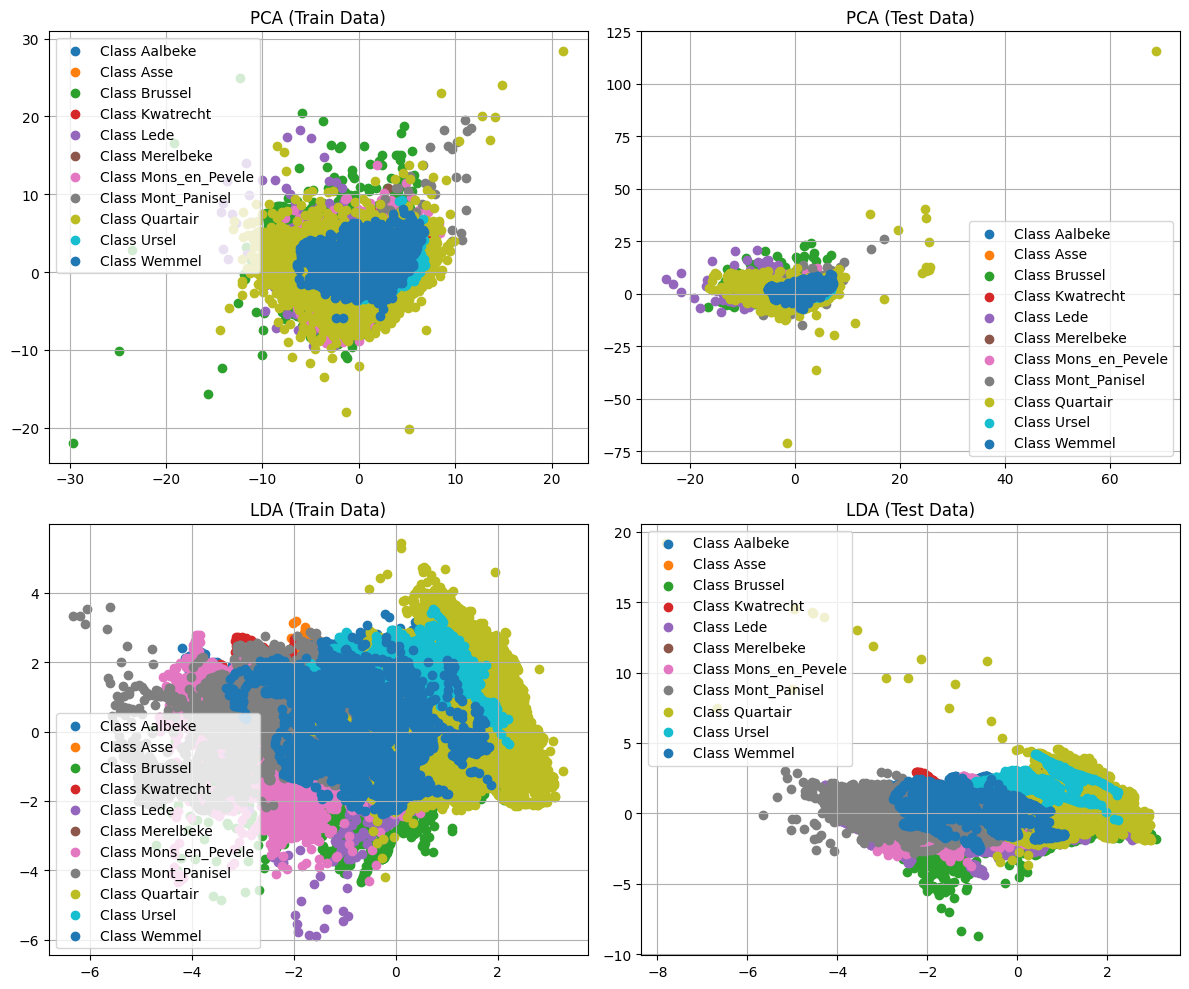

In [24]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[features])
X_test_std = scaler.transform(X_test[features])

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_std, y_train["lithostrat_id"])
X_test_lda = lda.transform(X_test_std)

def plot_projection(X_proj, y, title, ax):
    for label in np.unique(y):
        ax.scatter(
            X_proj[y == label, 0],
            X_proj[y == label, 1],
            label=f"Class {label}",
        )
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_projection(X_train_pca, y_train["lithostrat_id"], "PCA (Train Data)", axes[0, 0])
plot_projection(X_test_pca, y_test["lithostrat_id"], "PCA (Test Data)", axes[0, 1])
plot_projection(X_train_lda, y_train["lithostrat_id"], "LDA (Train Data)", axes[1, 0])
plot_projection(X_test_lda, y_test["lithostrat_id"], "LDA (Test Data)", axes[1, 1])

plt.tight_layout()
plt.show()

In [25]:
#This cell runs for approximately 4:30 minutes

#important
print(pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.sum())

#not important
X_train_proj = pca.transform(X_train_std)
X_train_recon = pca.inverse_transform(X_train_proj)
pca_recon_error = np.mean((X_train_std - X_train_recon) ** 2)
print("PCA reconstruction MSE (train):", pca_recon_error)

#not important 
silhouette_train_pca = silhouette_score(X_train_proj, y_train["lithostrat_id"])
print("PCA silhouette score (train):", silhouette_train_pca)

##important
X_test_proj = pca.transform(X_test_std)
silhouette_test_pca = silhouette_score(X_test_proj, y_test["lithostrat_id"])
print("PCA silhouette score (test):", silhouette_test_pca)

#important
print("LDA explained variance ratio:", lda.explained_variance_ratio_)

#important
scores_lda = cross_val_score(lda, X_train_std, y_train["lithostrat_id"], cv=5)
print("LDA cross-validated accuracy (train folds):", scores_lda.mean())

#important
X_train_lda_proj = lda.transform(X_train_std)
silhouette_train_lda = silhouette_score(X_train_lda_proj, y_train["lithostrat_id"])
print("LDA silhouette score (train):", silhouette_train_lda)

#not sure
test_accuracy = lda.score(X_test_std, y_test["lithostrat_id"])
print("LDA test set accuracy:", test_accuracy)

#important
X_test_lda_proj = lda.transform(X_test_std)
silhouette_test_lda = silhouette_score(X_test_lda_proj, y_test["lithostrat_id"])
print("LDA silhouette score (test):", silhouette_test_lda)

[3.44346698e-01 1.63257475e-01 1.46188639e-01 8.35590406e-02
 6.85798472e-02 5.42920948e-02 4.04751924e-02 2.52596960e-02
 1.90755471e-02 1.69215364e-02 9.37106347e-03 7.12053283e-03
 6.44239239e-03 6.19806271e-03 3.58319923e-03 2.16289150e-03
 1.80891638e-03 4.17436923e-04 3.26511683e-04 2.65193484e-04
 1.50451807e-04 1.27208811e-04 4.88045626e-05 1.49511451e-05
 6.61640374e-06]
Cumulative variance: 1.0
PCA reconstruction MSE (train): 6.906442998138726e-31
PCA silhouette score (train): -0.1295731817278297
PCA silhouette score (test): -0.07860460207698561
LDA explained variance ratio: [5.92589024e-01 2.51507476e-01 7.64677325e-02 4.57693403e-02
 2.76406085e-02 4.23803676e-03 1.18611106e-03 3.46800262e-04
 2.04275482e-04 5.05951705e-05]
LDA cross-validated accuracy (train folds): 0.552926902682541
LDA silhouette score (train): -0.06883011427843462
LDA test set accuracy: 0.5090853498733292
LDA silhouette score (test): -0.054360751667457366


In [26]:
y_pred = lda.predict(X_test_std)

report = classification_report(
    y_test["lithostrat_id"],
    y_pred,
    labels=y_test["lithostrat_id"].unique(),
    target_names=[str(c) for c in y_test["lithostrat_id"].unique()]
)

print(report)

                precision    recall  f1-score   support

      Quartair       0.64      0.81      0.72      5936
  Mont_Panisel       0.57      0.44      0.50      3073
       Aalbeke       0.29      0.80      0.43       307
Mons_en_Pevele       0.13      0.31      0.18       676
       Brussel       0.49      0.44      0.46      2909
         Ursel       0.37      0.56      0.45      1017
          Asse       0.34      0.37      0.36      1054
        Wemmel       0.56      0.55      0.56      1175
          Lede       0.54      0.34      0.42      5785
     Merelbeke       0.00      0.00      0.00       141
     Kwatrecht       0.34      0.18      0.24       821

      accuracy                           0.51     22894
     macro avg       0.39      0.44      0.39     22894
  weighted avg       0.52      0.51      0.50     22894



c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

In [27]:
lda = LDA()
lda_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('lda', lda)
])
lda_pipe.fit(X_train[features], y_train["lithostrat_id"])


lda_features = FunctionTransformer(
    func=lambda X: lda_pipe.named_steps['lda'].predict_proba(
        lda_pipe.named_steps['scaler'].transform(X)
    ),
    validate=False
)

stack_pipe = Pipeline([
    ('lda_probs', lda_features),
    ('rf', RandomForestClassifier(n_estimators=200,
    random_state=seed,
    class_weight='balanced'))
])

stack_pipe.fit(X_train[features], y_train["lithostrat_id"])


score = stack_pipe.score(X_test[features], y_test["lithostrat_id"])
print("Stacked pipeline accuracy:", score)

Stacked pipeline accuracy: 0.5481785620686643


In [28]:
y_pred = stack_pipe.predict(X_test[features])


report = classification_report(y_test["lithostrat_id"], y_pred, target_names=[str(c) for c in np.unique(y_train["lithostrat_id"])])
print(report)

                precision    recall  f1-score   support

       Aalbeke       0.41      0.74      0.52       307
          Asse       0.38      0.26      0.31      1054
       Brussel       0.48      0.45      0.46      2909
     Kwatrecht       0.66      0.35      0.46       821
          Lede       0.65      0.37      0.47      5785
     Merelbeke       0.00      0.00      0.00       141
Mons_en_Pevele       0.16      0.67      0.26       676
  Mont_Panisel       0.63      0.46      0.53      3073
      Quartair       0.70      0.95      0.81      5936
         Ursel       0.40      0.33      0.36      1017
        Wemmel       0.39      0.40      0.40      1175

      accuracy                           0.55     22894
     macro avg       0.44      0.45      0.42     22894
  weighted avg       0.58      0.55      0.54     22894

